In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression

from data_augmentation import augment_data

In [2]:
SEED=12345
np.random.seed(SEED) 
AUGMENTED_SIZE = 1000

In [3]:
dataframe = pd.read_excel("dataset/Data_set.xlsx")
dataframe.columns = ["id", "installation_name", "wall_area_m2", "inner_walls_area_m2",
 "roof_area_m2", "floor_area_2nd_floor_m2", "delivery_location",
 "number_of_windows_std_size", "number_of_windows_gre18_height", "number_sliding_doors",
"number_windows_doors", "number_doors", "price_6_10_sek_excl_tax", "snow_zone", "mounting", "price_sek_excl_tax_incl_6_10", "distance_location"]
dataframe["snow_zone"] = dataframe["snow_zone"].apply(lambda item: float(item) if type(item) != str else 2.25)

In [4]:
dataframe.head(3)

,id,installation_name,wall_area_m2,inner_walls_area_m2,roof_area_m2,floor_area_2nd_floor_m2,delivery_location,number_of_windows_std_size,number_of_windows_gre18_height,number_sliding_doors,number_windows_doors,number_doors,price_6_10_sek_excl_tax,snow_zone,mounting,price_sek_excl_tax_incl_6_10,distance_location
0,Villa 1,Vladimir,80,0,185,0.0,Esklistuna,8,1,1,1,2,171348.0,2.0,370000,605300,295
1,Villa 2,All In,270,50,110,72.0,Bankeryd,7,22,1,8,0,362700.0,2.5,No,1770300,24
2,Villa 3,Blidö,272,55,158,77.0,Stockholm,8,14,0,2,0,149494.0,2.0,No,1160300,337


In [5]:
selected_features = ['wall_area_m2',
 'number_of_windows_gre18_height',
 'number_sliding_doors',
 'number_doors',
 'snow_zone']

In [6]:
target = "price_sek_excl_tax_incl_6_10"

In [7]:
scaler = MinMaxScaler(feature_range=(0, 1))

In [8]:
X = scaler.fit_transform(dataframe[selected_features].to_numpy())
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
X = imputer.fit_transform(X)
y = dataframe[target].to_numpy()

In [9]:
df = pd.DataFrame(X, columns=selected_features)
df[target] = y

data_augmented = augment_data(df, target, selected_features, selected_features, AUGMENTED_SIZE)
X_augmented, y_augmented = data_augmented[selected_features].to_numpy(), data_augmented[target].to_numpy()

In [10]:
model = LinearRegression()
model.fit(X_augmented, y_augmented)

LinearRegression()

In [11]:
weights = model.coef_
bias = model.intercept_

print("Weights (Coefficients):", weights)
print("Bias (Intercept):", bias)

x_min = scaler.data_min_
x_max = scaler.data_max_
print("Mins:", x_min)
print("Maxs:", x_max)

Weights (Coefficients): [816151.27569005 544436.32465156 295032.05771667 172596.6603085
 371516.65946913]
Bias (Intercept): -24079.20369845163
Mins: [67.  1.  0.  0.  1.]
Maxs: [316.   22.    2.    2.    2.5]


In [12]:
# Compute adjusted weights (true contribution of each feature)
true_weights = weights / (x_max - x_min)

# Compute adjusted bias (intercept)
true_bias = bias - np.sum(weights * (x_min / (x_max - x_min)))

# Display the adjusted coefficients
print("Adjusted Weights (Impact in Original Scale):", list(true_weights))
print("Adjusted Bias (Intercept in Original Scale):", (true_bias))


Adjusted Weights (Impact in Original Scale): [3277.715966626689, 25925.539269121986, 147516.028858334, 86298.33015425023, 247677.77297942212]
Adjusted Bias (Intercept in Original Scale): -517289.48571098386


In [13]:
selected_features

['wall_area_m2',
 'number_of_windows_gre18_height',
 'number_sliding_doors',
 'number_doors',
 'snow_zone']

$$
y = -517289.4857 
+ (3277.7160 \cdot x_1) 
+ (25925.5393 \cdot x_2) 
+ (147516.0289 \cdot x_3)  
+ (86298.3302 \cdot x_4) 
+ (247677.7730 \cdot x_5)
$$

$$
y = -517289.4857 
+ (3277.7160 \cdot \text{wall_area_m2}) 
+ (25925.5393 \cdot \text{number_of_windows_gre18_height}) 
+ (147516.0289 \cdot \text{number_sliding_doors}) \newline
+ (86298.3302 \cdot \text{number_doors}) 
+ (247677.7730 \cdot \text{snow_zone})
$$

In [14]:
def predict_y(x, true_weights, true_bias):
    x = np.array(x)  # Ensure x is a NumPy array
    y_pred = np.dot(x, true_weights) + true_bias
    return y_pred
def static_predict_y(x):
    """
        selected_features: ['wall_area_m2',
         'number_of_windows_gre18_height',
         'number_sliding_doors',
         'number_doors',
         'snow_zone']
    """
    true_weights = [3277.715966626689, 25925.539269121986, 147516.028858334, 86298.33015425023, 247677.77297942212]
    true_bias = -517289.48571098386
    x = np.array(x)  # Ensure x is a NumPy array
    y_pred = np.dot(x, true_weights) + true_bias
    return y_pred

In [15]:
dataframe[selected_features].head()

,wall_area_m2,number_of_windows_gre18_height,number_sliding_doors,number_doors,snow_zone
0,80,1,1,2,2.00
1,270,22,1,0,2.50
2,272,14,0,0,2.00
3,207,14,1,2,1.50
4,100,10,0,0,2.25


In [16]:

idx = 0  # Change this to any index you want to test

sklearn_pred = model.predict(X[idx].reshape(1, -1))[0]  # Scikit-learn model prediction
manual_pred = predict_y(dataframe[selected_features].to_numpy()[idx], true_weights, true_bias)  # Adjusted weights
static_pred = static_predict_y(dataframe[selected_features].to_numpy()[idx])  # Custom function
real_value = y[idx]  # True target value


df_results = pd.DataFrame({
    "Model": ["Real Value", "model.predict", "predict_y", "static_predict_y"],
    "Prediction": [real_value, sklearn_pred, manual_pred, static_pred]
})

# Format numerical values with commas and 4 decimal places
df_results["Prediction"] = df_results["Prediction"].apply(lambda x: f"{x:,.4f}")
df_results

,Model,Prediction
0,Real Value,"605,300.0000"
1,model.predict,"586,321.5660"
2,predict_y,"586,321.5660"
3,static_predict_y,"586,321.5660"


# Visualizing predictions

In [17]:
dataframe["prediction"] = dataframe[selected_features].apply(static_predict_y,axis=1).astype(int)


In [18]:
from matplotlib import pyplot as plt
from results_utils import plot_predicted_vs_true_and_interval

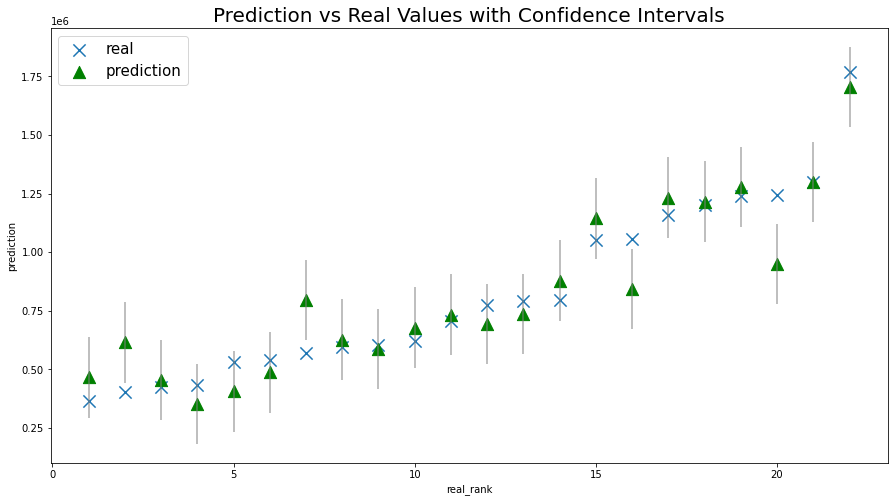

Margin of error based on t-distribution: 167565
Using a confidence interval for each side of 167,565, we get the real value 81.82% of the time.


In [19]:
results_dataframe = plot_predicted_vs_true_and_interval(dataframe, target, "prediction")

In [20]:

def format_kr(value):
    return f"{value:,.2f} kr"  # Formats with commas and two decimal places

# Apply formatting to relevant columns
results_dataframe[["real", "prediction", "error", "prediction_lower_bound", "prediction_upper_bound"]] = \
    results_dataframe[["real", "prediction", "error", "prediction_lower_bound", "prediction_upper_bound"]].applymap(format_kr)

In [21]:
results_dataframe[["real", "prediction", "error", "prediction_lower_bound", "prediction_upper_bound", "is_in_the_range"]]

,real,prediction,error,prediction_lower_bound,prediction_upper_bound,is_in_the_range
20,"367,300.00 kr","465,853.00 kr","98,553.00 kr","298,288.00 kr","633,417.00 kr",1
12,"405,300.00 kr","615,321.00 kr","210,021.00 kr","447,756.00 kr","782,885.00 kr",0
13,"425,300.00 kr","454,835.00 kr","29,535.00 kr","287,270.00 kr","622,399.00 kr",1
16,"435,000.00 kr","353,226.00 kr","-81,774.00 kr","185,661.00 kr","520,790.00 kr",1
21,"530,000.00 kr","406,976.00 kr","-123,024.00 kr","239,411.00 kr","574,540.00 kr",1
9,"538,300.00 kr","488,083.00 kr","-50,217.00 kr","320,518.00 kr","655,647.00 kr",1
11,"569,300.00 kr","795,595.00 kr","226,295.00 kr","628,030.00 kr","963,159.00 kr",0
4,"595,300.00 kr","627,012.00 kr","31,712.00 kr","459,447.00 kr","794,576.00 kr",1
0,"605,300.00 kr","586,321.00 kr","-18,979.00 kr","418,756.00 kr","753,885.00 kr",1
6,"619,300.00 kr","677,894.00 kr","58,594.00 kr","510,329.00 kr","845,458.00 kr",1
